# Examples

Here we show how you can generate the pattern-based embedding of
a time series in a number of ways. Specifically, we show how to
handle both univariate time series and multivariate time series. We
also provide an example of how to use ``PaTSEmb`` for learning the
typical patterns in a collection of time series. Finally, we also show how to compute the embedding in an online manner.

The code below is necessary to initialize a pattern-based embedder. We will use this embedder throughout all examples.

In [1]:
# Some additional imports
import numpy as np  # For creating/loading time series
np.random.seed(0)

In [2]:
from patsemb.discretization import SAXDiscretizer
from patsemb.pattern_mining import QCSP
from patsemb.pattern_based_embedding import PatternBasedEmbedder, plot_time_series_and_embedding, plot_time_series, plot_embedding

# Specify a discretizer and pattern miner, or use the default values
pattern_based_embedder = PatternBasedEmbedder(
    discretizer=SAXDiscretizer(alphabet_size=8, word_size=5),
    pattern_miner=QCSP(minimum_support=3, top_k_patterns=20)
)

## Univariate time series

In its easiest form, ``PaTSEmb`` can be used to embed univariate time series. Below we show how to embed a sine wave with some Gaussian noise. ``PaTSEmb`` follows as much as possible the typical Python conventions via the following methods:

- ``fit(X, y)``: Transform the time series into a symbolic representation and mine the sequential patterns in it. Some ground truth ``y`` can be provided, but most often this will be ignored by the discretizer and pattern miner.
- ``transform(X)``: Transform the time series into a symbolic representation and locate where the mined patterns are. These locations are then used to create the pattern-based embedding.
- ``fit_transform(X, y)``: Chain the ``fit(X, y)`` and ``transform(X)`` methods.

The `PatternBasedEmbedder` does not have a ``predict(X)`` method, because prediction is part of the downstream task. Below, we show how to embed a simple univariate time series.

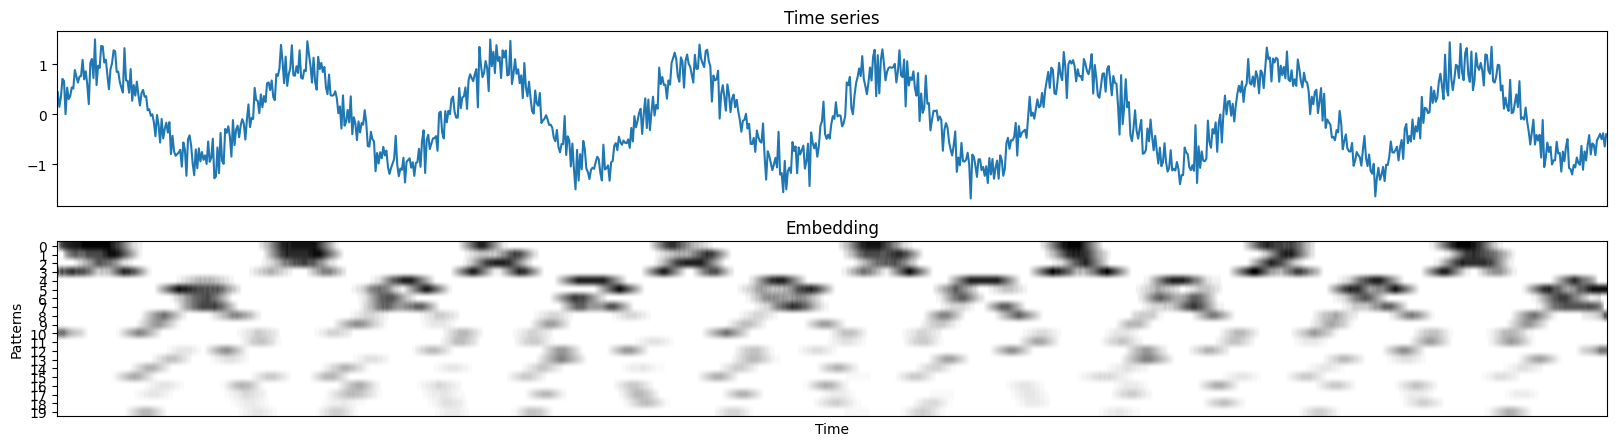

In [3]:
# Initialize the time series
univariate_time_series = np.sin(np.arange(0, 50, 0.05)) + np.random.normal(0, 0.25, 1000)

# Create the embedding
embedding = pattern_based_embedder.fit_transform(univariate_time_series)

# Visualize
plot_time_series_and_embedding(univariate_time_series, embedding).savefig('figures/example-univariate-time-series')

## Multivariate time series

Handling multivariate is exactly the same as handling univariate time series, as illustrated by the code below. The used data for this example can be found on [this GitHub repository](https://github.com/zedshape/zgrouping/blob/main/datasets/synthetic_data.pickle). For multivariate time series, patterns are mined in each attribute. The created embeddings are consequently concatenated.

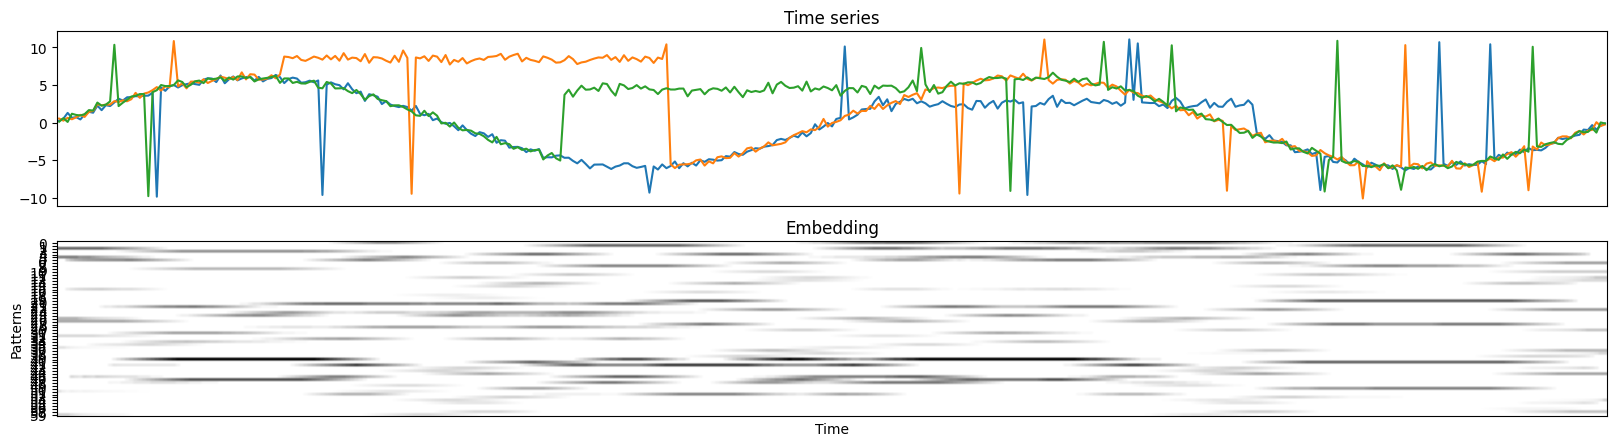

In [4]:
# Initialize the time series
multivariate_time_series = np.load('../data/z-grouping-synthetic.pickle', allow_pickle=True)['X'][:3].T

# Create the embedding
embedding = pattern_based_embedder.fit_transform(multivariate_time_series)

# Visualize
plot_time_series_and_embedding(multivariate_time_series, embedding).savefig('figures//example-multivariate-time-series')

## Collection of time series

While you can only pass a single time series to the ``transform(X)`` method, to embed a single time series, it is possible to learn the patterns from a collection of time series in the ``fit(X, y)``. Next, you can embed another time series using the mined patterns, without every having mined patterns in it. In the code below, we treat the attributes from the multivariate example above as univariate time series. The embedder is fitted using the orange and green time series, and then we create the embedding for blue time series.

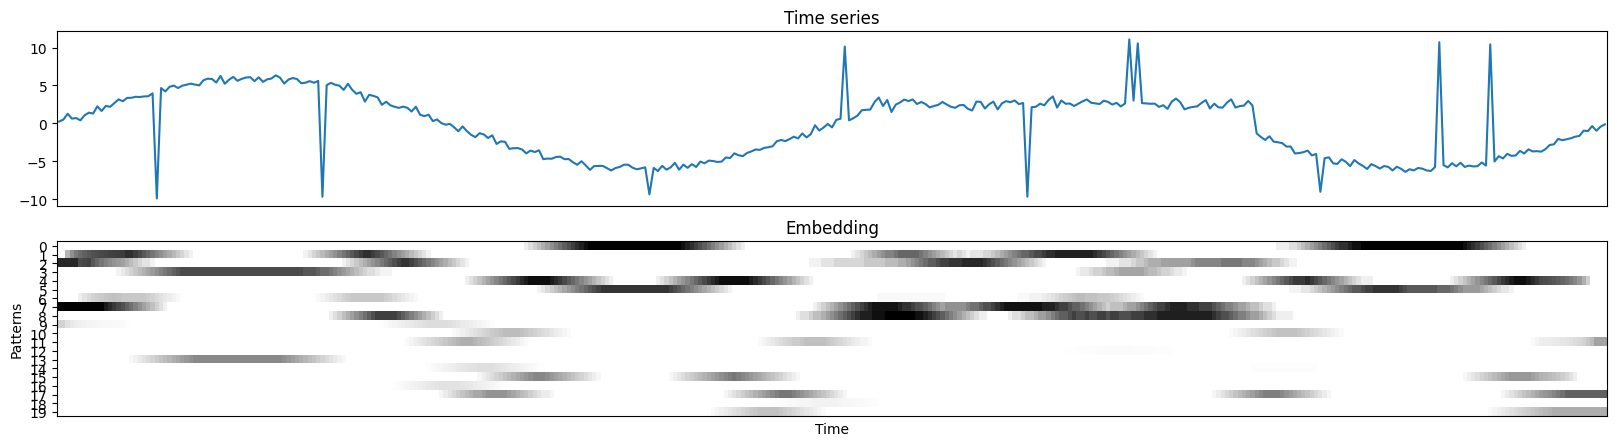

In [5]:
# Initialize a collection of time series
collection_of_time_series = [time_series for time_series in np.load('../data/z-grouping-synthetic.pickle', allow_pickle=True)['X'][:3]]

# Fit the embedding using the collection of time series, except the first time series
pattern_based_embedder.fit(collection_of_time_series[1:])
embedding = pattern_based_embedder.transform(collection_of_time_series[0])

# Visualize the embedding of the first time series, which was not used for fitting
plot_time_series_and_embedding(collection_of_time_series[0], embedding).savefig('figures/example-collection-of-time-series')

## Batched online pattern-based embedding

In [6]:
# Initialize the time series
univariate_time_series = np.sin(np.arange(0, 25, 0.025)) + np.random.normal(0, 0.25, 1000)

# Create the batches
nb_batches = 5
batch_size = univariate_time_series.shape[0]//nb_batches
batches = [univariate_time_series[batch_id*batch_size:(batch_id+1)*batch_size] for batch_id in range(nb_batches)]

# Fit on the first batch, but transform all batches
pattern_based_embedder.fit(batches[0])
embedding_per_batch = [pattern_based_embedder.transform(batch) for batch in batches]

This is some wrapper code to plot the embedding of the different batches. 

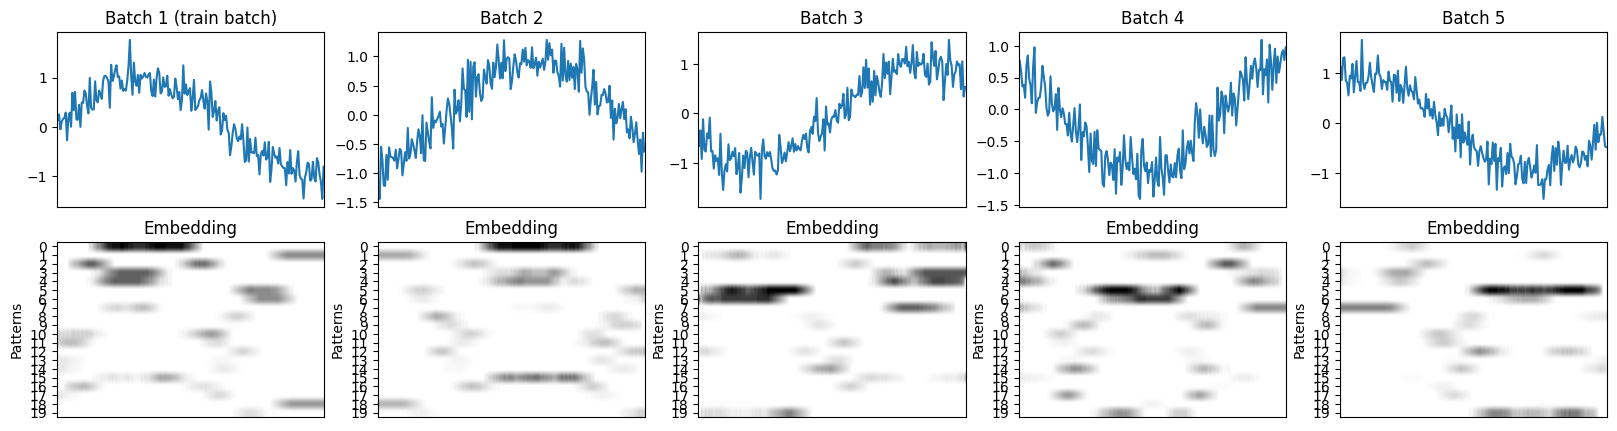

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, nb_batches, figsize=(20, 5), sharex='all')
for i, (batch, embedding) in enumerate(zip(batches, embedding_per_batch)):
    plot_time_series(axs[0][i], batch)
    axs[0][i].set_title(f'Batch {i+1}{" (train batch)" if i == 0 else ""}')
    plot_embedding(axs[1][i], embedding)
fig.savefig('figures/example-batched-online-pattern-based-detection')